In [68]:
import plotly.express as px
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output, State
import pandas as pd

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft
from IPython.display import clear_output
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from PIL import Image
from nibabel.testing import data_path
import os
import sys
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go

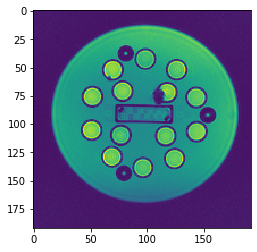

In [60]:
import pydicom
MapAngles_defaut = np.zeros([192,192,7])
MapAngles_defaut[:,:,0] = pydicom.read_file("AGAH_NIST_ACHILLE.MR.IRM_RECHERCHE_NIKOLA_STIKOV.0003.0009.2020.11.19.21.00.11.258356.259817697.IMA").pixel_array
#MapAngles_defaut[:,:,0] = pydicom.read_file("AGAH_NIST_ACHILLE.MR.IRM_RECHERCHE_NIKOLA_STIKOV.0009.0009.2020.11.19.21.00.11.258356.259823853.IMA").pixel_array
MapAngles_defaut[:,:,1] = pydicom.read_file("AGAH_NIST_ACHILLE.MR.IRM_RECHERCHE_NIKOLA_STIKOV.0004.0009.2020.11.19.21.00.11.258356.259818723.IMA").pixel_array
MapAngles_defaut[:,:,2] = pydicom.read_file("AGAH_NIST_ACHILLE.MR.IRM_RECHERCHE_NIKOLA_STIKOV.0005.0009.2020.11.19.21.00.11.258356.259819749.IMA").pixel_array
MapAngles_defaut[:,:,3] = pydicom.read_file("AGAH_NIST_ACHILLE.MR.IRM_RECHERCHE_NIKOLA_STIKOV.0006.0009.2020.11.19.21.00.11.258356.259820775.IMA").pixel_array
MapAngles_defaut[:,:,4] = pydicom.read_file("AGAH_NIST_ACHILLE.MR.IRM_RECHERCHE_NIKOLA_STIKOV.0007.0009.2020.11.19.21.00.11.258356.259821801.IMA").pixel_array
MapAngles_defaut[:,:,5] = pydicom.read_file("AGAH_NIST_ACHILLE.MR.IRM_RECHERCHE_NIKOLA_STIKOV.0008.0009.2020.11.19.21.00.11.258356.259822827.IMA").pixel_array
MapAngles_defaut[:,:,6] = pydicom.read_file("AGAH_NIST_ACHILLE.MR.IRM_RECHERCHE_NIKOLA_STIKOV.0009.0009.2020.11.19.21.00.11.258356.259823853.IMA").pixel_array

plt.imshow(MapAngles_defaut[:,:,1])

In [4]:
from scipy.optimize import leastsq
def residual(variables, x, data, M0,eps_data):
    """Model a decaying sine wave and subtract data."""
    T1 = variables[0]

    model = M0*((1-np.exp(-15/T1))/(1-np.cos(np.deg2rad(x))*np.exp(-15/T1)))*np.sin(np.deg2rad(x))

    return (data-model) / eps_data

In [5]:
def T1_non_lin(MapAngles, angles, TF, T1_estim):
    eps_data =1
    variables = [1000]
    T1graph = np.ones([MapAngles.shape[0], MapAngles.shape[1]])
    for i in range(0, MapAngles.shape[0]):  
        for j in range(0,MapAngles.shape[1]):
            coordx=i
            coordy=j
            Magnt = MapAngles[coordx, coordy, :]
            T1 = leastsq(residual, variables, args=(angles, Magnt, 5000, eps_data))[0] #M0 estimé à partir des valeurs du signal par rapport à celles simulées avec M0 = 1
            if(T1<4000 and T1>0): 
                T1graph[coordx][coordy] = T1
    return T1graph

In [6]:
def T1_lin(Map1, Map2, angles, TF): #B1?
    T1graph = np.zeros(Map1.shape)
    for i in range(0,Map1.shape[0]):
        for j in range(0,Map1.shape[1]):
            coordx=i
            coordy=j
            pente = ((Map2[coordx][coordy]/np.sin(np.deg2rad(angles[1])))-(Map1[coordx][coordy]/np.sin(np.deg2rad(angles[0]))))/((Map2[coordx][coordy]/np.tan(np.deg2rad(angles[1])))-(Map1[coordx][coordy]/np.tan(np.deg2rad(angles[0]))))
            if (pente > 0):
                T1 = -TF/(np.log(pente))
                if (T1 < 4000) and (T1 > 0):
                    T1graph[coordx][coordy] = T1
    return T1graph

In [7]:
def load_image(MapAngles, adresse, position):
    image = pydicom.read_file(adresse).pixel_array
    if (position >= MapAngles[0,0,:].size):
        Map_temp = np.zeros([192, 192, position+1])
        for i in range (0, position):
            Map_temp[:,:,i] = MapAngles[:,:,i]
        MapAngles = Map_temp
        MapAngles[:,:,position]=image
    else:
        MapAngles[:,:,position]=image
    return MapAngles

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


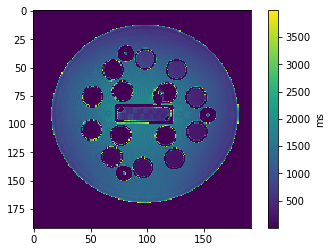

1467.8847173299605


In [8]:
angles = np.array([3.0,5.0,10.0,15.0,20.0,25.0,30.0])
T1graph_non_lin = T1_non_lin(MapAngles, angles, 15, 1000)
angles = np.array([3.0, 30.0])
T1graph_lin = T1_lin(MapAngles[:,:,0], MapAngles[:,:,6], angles, 15)
plt.imshow(T1graph_non_lin, interpolation='nearest')
cb = plt.colorbar()
cb.set_label('ms')
plt.show()
print(T1graph_non_lin[60][60])

In [41]:
import codecs, json 

In [86]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning:

invalid value encountered in double_scalars



In [85]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = JupyterDash(__name__, external_stylesheets=external_stylesheets, suppress_callback_exceptions=True)

all_options = {
    '3 deg': [],
    '5 deg': [],
    '10 deg': [],
    '15 deg': [],
    '20 deg': [],
    '25 deg': [],
    '30 deg': []
} 
MapAngles_new = np.zeros([192,192,1])
app.layout = html.Div([
    html.Div([
    dcc.Input(id='input-1-state', type='text', value='Montréal'),
    dcc.Input(id='input-2-state', type='number', value=0),
    html.Button(id='submit-button-state', n_clicks=0, children='Submit'),
    html.Div(id='output-state')
]),
    html.Div([
        html.Button(id='calcul', n_clicks=0, children='Submit'),
]),
    dcc.RadioItems(
        id='angles',
        options=[{'label': k, 'value': k} for k in all_options.keys()],
        value='3 deg'
    ),

    html.Hr(),

    dcc.RadioItems(
        id='methodes',
        options=[{'label': k, 'value': k} for k in ['T1 lin', 'T1 non_lin']],
        value='T1 linéaire'
    ),
    html.Hr(),
    dcc.Input(
        id='coordx',
        type='number',
        value=90
    ),
    dcc.Input(
        id='coordy',
        type='number',
        value=90
    ),
    
    html.Hr(),
    html.Div(id='intermediate-value', style={'display': 'none'}),
    html.Div([
    dcc.Graph(
        id='angle-graph',
        figure=px.imshow(MapAngles_defaut[:,:,0], range_color=[0, 3500])
    )], style={'width': '25%', 'display': 'inline-block', 'padding': '0 20'}),
    html.Div([
    dcc.Graph(
        id='T1-graph',
        figure=px.imshow(np.zeros([192, 192]))
    )], style={'display': 'inline-block', 'width': '25%'}),
    html.Div([
    dcc.Graph(id='indicator-graphic')
    ], style={'display': 'inline-block', 'width': '50%'})
])



@app.callback(
    Output('intermediate-value', 'children'),
    Input('submit-button-state', 'n_clicks'),
    State('input-1-state', 'value'),
    State('input-2-state', 'value'),
    State('intermediate-value', 'children')
)
def clean_data(bouton, value, position, MapAngles_new):
    if(MapAngles_new == None):
        MapAngles_new = MapAngles_defaut
    else:
        json_load = json.loads(MapAngles_new)
        MapAngles_new = np.asarray(json_load["b"])
    MapAngles_new = load_image(MapAngles_new, value, position)
    b = MapAngles_new.tolist() 
    return json.dumps({'b': b}, cls=NumpyEncoder)

@app.callback(
    Output('angle-graph', 'figure'),
    Input('calcul', 'n_clicks'),
    Input('angles', 'value'),
    State('intermediate-value', 'children')
)
def update_figure(calcul, selected_country, MapAngles_affichage):
    if(MapAngles_affichage == None):
        MapAngles_affichage = MapAngles_defaut
    else:
        json_load = json.loads(MapAngles_affichage)
        MapAngles_affichage = np.asarray(json_load["b"])
    if (selected_country == '3 deg'):
        fig = px.imshow(MapAngles_affichage[:,:,0], range_color=[0, 3500])
    if (selected_country == '5 deg'):
        fig = px.imshow(MapAngles_affichage[:,:,1], range_color=[0, 3500])  
    if (selected_country == '10 deg'):
        fig = px.imshow(MapAngles_affichage[:,:,2], range_color=[0, 3500])
    if (selected_country == '15 deg'):
        fig = px.imshow(MapAngles_affichage[:,:,3], range_color=[0, 3500])
    if (selected_country == '20 deg'):
        fig = px.imshow(MapAngles_affichage[:,:,4], range_color=[0, 3500])
    if (selected_country == '25 deg'):
        fig = px.imshow(MapAngles_affichage[:,:,5], range_color=[0, 3500])
    if (selected_country == '30 deg'):
        fig = px.imshow(MapAngles_affichage[:,:,6], range_color=[0, 3500])     
    return fig

@app.callback(
    Output('T1-graph', 'figure'),
    Input('methodes', 'value'),
    Input('calcul', 'n_clicks'),
    State('intermediate-value', 'children'),
)
def update_figure2(selected_method, bouton, MapAngles_T1):
    if(MapAngles_T1 == None):
        MapAngles_T1 = MapAngles_defaut
    else:
        json_load = json.loads(MapAngles_T1)
        MapAngles_T1 = np.asarray(json_load["b"])
    if (selected_method == 'T1 non_lin'):
        angles = np.array([3.0,5.0,10.0,15.0,20.0,25.0,30.0])
        T1graph_non_lin = T1_non_lin(MapAngles_T1, angles, 15, 1000)
        fig = px.imshow(T1graph_non_lin, range_color=[0, 3500])
    if (selected_method == 'T1 lin'):
        angles = np.array([3.0,30.0])
        T1graph_lin = T1_lin(MapAngles_T1[:,:,0],MapAngles_T1[:,:,6], angles, 15)
        fig = px.imshow(T1graph_lin, range_color=[0, 3500])   
    return fig

@app.callback(
    Output('indicator-graphic', 'figure'),
    Input('coordx', 'value'),
    Input('coordy', 'value'),
    Input('calcul', 'n_clicks'),
    State('intermediate-value', 'children'),
)

def update_figure3(selected_coordx, selected_coordy, bouton, MapAngles_courbes):
    if(MapAngles_courbes == None):
        MapAngles_courbes = MapAngles_defaut
    else:
        json_load = json.loads(MapAngles_courbes)
        MapAngles_courbes = np.asarray(json_load["b"])
    angles = np.array([3.0,5.0,10.0,15.0,20.0,25.0,30.0])
    angles2 = np.array([3.0, 30.0])
    pente = ((MapAngles_courbes[selected_coordx, selected_coordy,6]/np.sin(np.deg2rad(angles2[1])))-(MapAngles_courbes[selected_coordx, selected_coordy,0]/np.sin(np.deg2rad(angles2[0]))))/((MapAngles_courbes[selected_coordx, selected_coordy,6]/np.tan(np.deg2rad(angles2[1])))-(MapAngles_courbes[selected_coordx, selected_coordy,0]/np.tan(np.deg2rad(angles2[0]))))
    if (pente > 0):
        T1lin = -15/(np.log(pente))
    T1non_lin = leastsq(residual, 1000, args=(angles, MapAngles_courbes[selected_coordx, selected_coordy,:], 5000, 1))[0]
    model_lin = 5000*((1-np.exp(-15/T1lin))/(1-np.cos(np.deg2rad(angles))*np.exp(-15/T1lin)))*np.sin(np.deg2rad(angles))
    model_non_lin = 5000*((1-np.exp(-15/T1non_lin))/(1-np.cos(np.deg2rad(angles))*np.exp(-15/T1non_lin)))*np.sin(np.deg2rad(angles))
    fig = px.scatter(x=angles, y=MapAngles_courbes[selected_coordx, selected_coordy, :])
    if (T1lin):
        fig.add_trace(go.Scatter(x=angles, y=model_lin))
    fig.add_trace(go.Scatter(x=angles, y=model_non_lin))
    return fig

if __name__ == '__main__':
#    app.run_server(debug=True)
    app.run_server(mode='external', port=8060)

Dash app running on http://127.0.0.1:8060/


C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:152: RuntimeWarning:

invalid value encountered in double_scalars

